In [796]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
import random
from collections import Counter
import sys
%matplotlib inline

# Our City

These are constants that define the behaviour of the city - 

In [797]:
CITY_POPULATION = 10000
MEAN_NETWORK_DEGREE = 50
MEAN_INTERACTIONS_PER_DAY = 20


The city is modeled as a small-world network graph (https://en.wikipedia.org/wiki/Small-world_network)

The graph is generated using the Watts–Strogatz model (https://en.wikipedia.org/wiki/Watts%E2%80%93Strogatz_model)

In [798]:
BETA = 0.5 # a parameter for the Watts–Strogatz read wiki page for more details
city_social_network = nx.watts_strogatz_graph(CITY_POPULATION, MEAN_NETWORK_DEGREE, BETA)


### Network characteristics

Let's look at the distribution of number of connections each person has in the city

<BarContainer object of 33 artists>

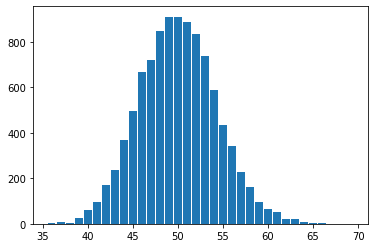

In [799]:
degrees = dict(city_social_network.degree()).values()
degree_counts = np.unique(list(degrees), return_counts = True)
degree_counts
plt.bar(degree_counts[0], degree_counts[1]) 


Age is an important characteristic in the prognosis of many diseases, including COVID'19

We model our city's population's age on that of the USA.
Based on 2000 Census data (https://www.census.gov/prod/cen2010/briefs/c2010br-03.pdf)

In [800]:
age_group_numbers_USA = [19175798,20549505,20528072,20219890,18964001,19381336,20510388,22706664,22441863, 20092404,17585548,13469237, 10805447,9533545,8857441,7415813,4945367,2789818,1112531,286784,50454,]

Each age group is of 5 years - under 5yo, 5-10, 10-15 .... 95-100, >100

For convenience, we choose a representative age for each group

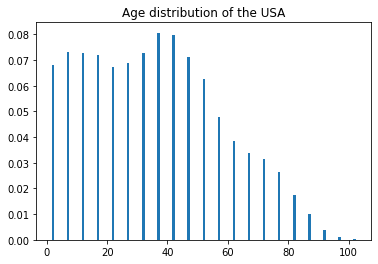

In [801]:
age_group_ratios = np.array(age_group_numbers_USA)/sum(age_group_numbers_USA)
ages = [2, 7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82, 87, 92, 97, 102]
plt.bar(ages, age_group_ratios)
plt.title('Age distribution of the USA')
plt.show()

Assigning an age to each person in our city

In [802]:
city_ages = np.random.choice(ages, CITY_POPULATION, p = age_group_ratios)

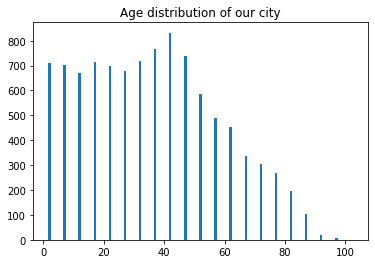

In [803]:
age_dist = np.unique(city_ages, return_counts = True)
plt.bar(age_dist[0], age_dist[1])
plt.title('Age distribution of our city')
plt.show()

Wrapping all of this into a single function for convenience, and initializing some other parameters 

In [804]:
def init_city():
    city_social_network = nx.watts_strogatz_graph(CITY_POPULATION, MEAN_NETWORK_DEGREE, BETA)
    city_ages = np.random.choice(ages, CITY_POPULATION, p = age_group_ratios)
    for i in range(CITY_POPULATION):
        city_social_network.nodes[i]['age'] = city_ages[i]
        city_social_network.nodes[i]['infected'] = False
        city_social_network.nodes[i]['alive'] = True
        city_social_network.nodes[i]['isolated'] = False
        city_social_network.nodes[i]['infected_date'] = sys.maxsize
        city_social_network.nodes[i]['recovered'] = False
    return city_social_network


# Our disease
Some parameters that define our disease

In [805]:
TRANSMISSION_RATE = 1.0/100
ILLNESS_LENGTH_DAYS = 14
SYMPTOMATIC_RATE = 0.5

We define a probabilty function of the disease being fatal - based on the age of the patient

In [822]:
def mortality_pdf(age):
    # a slightly simplistic placeholder 
    return ((age-102)/1020 +0.2)

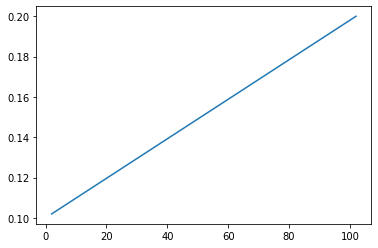

In [823]:
plt.plot(ages,[mortality_pdf(age) for age in ages])

# Now, the actual simulations

In [824]:
def get_disease_stats(city_graph):
    """
    Look at the disease spread in the population
    """
    total_infected = 0
    total_dead = 0
    total_healthy = 0
    total_recovered = 0
    for i in city_graph.nodes():
        if not city_graph.nodes[i]['alive']:
            total_dead+=1
        #dead people are not infected
        elif city_graph.nodes[i]['infected']:
            total_infected +=1
        elif city_graph.nodes[i]['recovered']:
            total_recovered +=1
        
        else:
            total_healthy+=1
    return{'infected':total_infected, 'dead': total_dead, 'never infected':total_healthy, 'recovered': total_recovered}
        
        

Based on the previously defined behaviour of our citizens, we generate a set of 'interactions' for the day. An interaction is a meeting between two people that may spread the disease

The below function assumes no preventative measures are made at all

In [825]:
def get_daily_visits_no_preventative_measures(city_graph):
    total_visits_in_day = (len(city_graph.nodes)*MEAN_INTERACTIONS_PER_DAY)/2 # Two people take part in an interaction
    day_visits = random.sample(list(city_graph.edges), int(total_visits_in_day))
    return day_visits
    

Distribution of Interactions on Day 0 (by person):

In [826]:
day_0_interactions = get_daily_visits(city_social_network)
interactions_per_person = Counter()
for interaction in day_0_interactions:
    interactions_per_person[interaction[0]]+=1
    interactions_per_person[interaction[1]]+=1
    

<BarContainer object of 28 artists>

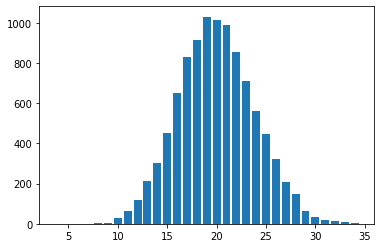

In [827]:
hist = np.unique(list(interactions_per_person.values()), return_counts = True)
plt.bar(hist[0],hist[1])

In [828]:

def simulate_single_day(city_graph, day_number):
    
    interactions = get_daily_visits_no_preventative_measures(city_graph)
    
    for p1,p2 in interactions:
        if not city_graph.nodes[p1]['alive'] or not city_graph.nodes[p1]['alive']:
            continue
        if city_graph.nodes[p1]['infected'] and city_graph.nodes[p2]['infected']:
            continue
        if city_graph.nodes[p1]['recovered'] or city_graph.nodes[p2]['recovered']:
            continue
        if not city_graph.nodes[p1]['infected'] and not city_graph.nodes[p2]['infected']:
            continue
        # one of the people is infected.
        if random.uniform(0, 1) < TRANSMISSION_RATE:
            #infect!
            if not city_graph.nodes[p1]['infected']:
                
                city_graph.nodes[p1]['infected'] = True
                city_graph.nodes[p1]['infected_date'] = day_number
            else:
                
                city_graph.nodes[p2]['infected'] = True
                city_graph.nodes[p2]['infected_date'] = day_number
    for p in city_graph.nodes():
        if day_number - city_graph.nodes[p]['infected_date'] == ILLNESS_LENGTH_DAYS:
            if random.uniform(0, 1) < mortality_pdf(city_graph.nodes[p]['age']) :
                city_graph.nodes[p]['alive'] = False
            else:
                city_graph.nodes[p]['recovered'] = True
                city_graph.nodes[p]['infected'] = False
  

In [829]:
def simulate_disease_spread():
    city_social_network = init_city()
    daily_stats = []
    city_social_network.nodes[0]['infected'] = True
    city_social_network.nodes[0]['infected_date'] = 0
    total_infections = 1
    day=0
    while total_infections>0:
        simulate_single_day(city_social_network,day)
        daily_stats.append(get_disease_stats(city_social_network))
        if day%10==0:
            print('day:'+str(day))
            print(daily_stats[-1])
        total_infections = daily_stats[-1]['infected']
        day+=1
    return daily_stats
simulate_disease_spread()

day:0
{'infected': 1, 'dead': 0, 'never infected': 9999, 'recovered': 0}
day:10
{'infected': 12, 'dead': 0, 'never infected': 9988, 'recovered': 0}
day:20
{'infected': 74, 'dead': 1, 'never infected': 9920, 'recovered': 5}
day:30
{'infected': 408, 'dead': 3, 'never infected': 9550, 'recovered': 39}
day:40
{'infected': 1807, 'dead': 22, 'never infected': 7969, 'recovered': 202}
day:50
{'infected': 4625, 'dead': 151, 'never infected': 4231, 'recovered': 993}
day:60
{'infected': 4309, 'dead': 574, 'never infected': 1551, 'recovered': 3566}
day:70
{'infected': 1495, 'dead': 1057, 'never infected': 778, 'recovered': 6670}
day:80
{'infected': 403, 'dead': 1225, 'never infected': 557, 'recovered': 7815}
day:90
{'infected': 168, 'dead': 1272, 'never infected': 453, 'recovered': 8107}
day:100
{'infected': 86, 'dead': 1286, 'never infected': 400, 'recovered': 8228}
day:110
{'infected': 63, 'dead': 1292, 'never infected': 365, 'recovered': 8280}
day:120
{'infected': 44, 'dead': 1303, 'never infec

[{'infected': 1, 'dead': 0, 'never infected': 9999, 'recovered': 0},
 {'infected': 1, 'dead': 0, 'never infected': 9999, 'recovered': 0},
 {'infected': 1, 'dead': 0, 'never infected': 9999, 'recovered': 0},
 {'infected': 1, 'dead': 0, 'never infected': 9999, 'recovered': 0},
 {'infected': 1, 'dead': 0, 'never infected': 9999, 'recovered': 0},
 {'infected': 5, 'dead': 0, 'never infected': 9995, 'recovered': 0},
 {'infected': 6, 'dead': 0, 'never infected': 9994, 'recovered': 0},
 {'infected': 8, 'dead': 0, 'never infected': 9992, 'recovered': 0},
 {'infected': 8, 'dead': 0, 'never infected': 9992, 'recovered': 0},
 {'infected': 10, 'dead': 0, 'never infected': 9990, 'recovered': 0},
 {'infected': 12, 'dead': 0, 'never infected': 9988, 'recovered': 0},
 {'infected': 17, 'dead': 0, 'never infected': 9983, 'recovered': 0},
 {'infected': 20, 'dead': 0, 'never infected': 9980, 'recovered': 0},
 {'infected': 24, 'dead': 0, 'never infected': 9976, 'recovered': 0},
 {'infected': 27, 'dead': 0, 

In [842]:
def plot_infection_progression(daily_stats):
    df = pd.DataFrame(daily_stats)
    colors = [[0.5,0.5,0.5], [0.6,0,0], [0,0.5,0],[0,0.75,0] ] # grey, red, light green, dark green
    ax = df.plot(y = ['dead', 'infected', 'recovered', 'never infected'], color = colors)
    ax.set_xlabel('Days')
    ax.set_ylabel('Number of people')
    plt.show()
    
    ax = df.plot.area(y = ['dead', 'infected', 'recovered', 'never infected'], color = colors)
    ax.set_xlabel('Days')
    ax.set_ylabel('Number of people')
    plt.show()
  

    

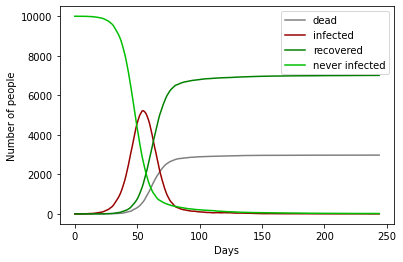

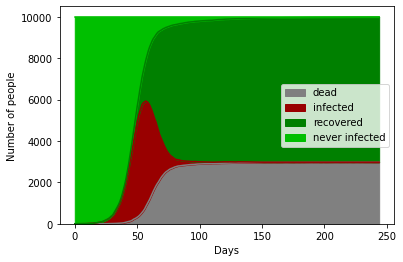

In [843]:
plot_infection_progression(daily_stats)